In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [28]:
data = pd.read_csv(r"C:\Users\brand\OneDrive\Documents\Bootcamp Projects\Capstone Project 2\Cleaned Data\cleaned_data")
data = data.drop(['Unnamed: 0','Name','Year_of_Release','Publisher','NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales','Developer'], axis=1)

In [29]:
data.head()
data.shape

(1688, 8)

<BarContainer object of 1688 artists>

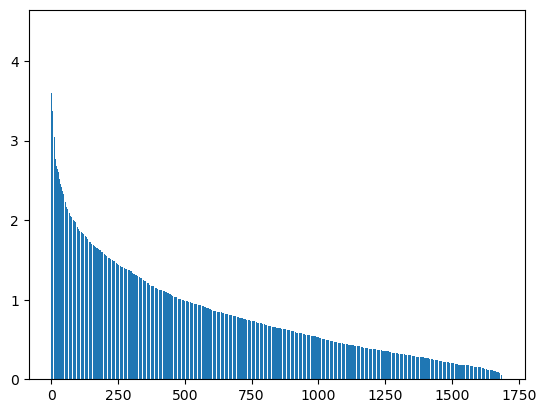

In [30]:
# I did some digging and learned about np.log,np.log(x),np.log1p 
#https://numpy.org/doc/stable/reference/generated/numpy.log.html
# it help my model performance a little
data['Global_Sales'] = np.log1p(data['Global_Sales'])
plt.bar(x=range(len(data['Global_Sales'])), height=data['Global_Sales'])


Valid records left:
 (1270,)
filtered data descrption: 
 count    1270.000000
mean        0.667918
std         0.335018
min         0.190620
25%         0.385262
50%         0.615186
75%         0.912283
max         1.430311
Name: Global_Sales, dtype: float64


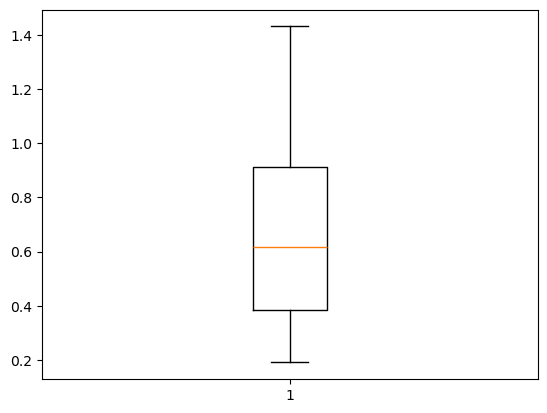

In [31]:
# filtering for lower 10% and  higher 85% quantiles of Global Sales. 
# Settled here because it left me enough data and filterd most of the extreme outliers.


l_quant = data['Global_Sales'].quantile(0.10)
h_quant = data['Global_Sales'].quantile(0.85)
data_filtered = data[(data['Global_Sales'] >= l_quant) & (data['Global_Sales'] <= h_quant)]

plt.boxplot(data_filtered['Global_Sales'])
print('Valid records left:\n',data_filtered['Global_Sales'].shape)
print("filtered data descrption: \n",data_filtered['Global_Sales'].describe())


In [32]:
#Label Encoding
df = data_filtered
le = LabelEncoder()
df.loc[:,'Platform'] = le.fit_transform(df['Platform'])

df.loc[:,'Genre'] = le.fit_transform(df['Genre'])

df.loc[:,'Rating'] = le.fit_transform(df['Rating'])

In [33]:
df

,Platform,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
254,9,0,1.430311,91,79,8.6,565,3
255,6,0,1.430311,62,30,8.1,137,4
256,9,7,1.430311,83,67,8.0,463,4
257,13,3,1.427916,82,63,7.6,85,4
258,7,1,1.427916,89,78,7.7,1010,3
...,...,...,...,...,...,...,...,...
1519,13,0,0.190620,55,22,6.8,16,3
1520,6,10,0.190620,68,16,8.5,15,0
1521,2,7,0.190620,69,46,6.5,15,0
1522,11,0,0.190620,70,35,7.8,24,3


In [34]:
#model building
model = RandomForestRegressor(n_estimators=10,max_depth=32, random_state=16)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=32, n_estimators=10, random_state=16)

        Feature  Importance
5    User_Count    0.306280
2  Critic_Score    0.158263
3  Critic_Count    0.147037
4    User_Score    0.127743
0      Platform    0.103795
6        Rating    0.087937
1         Genre    0.068945


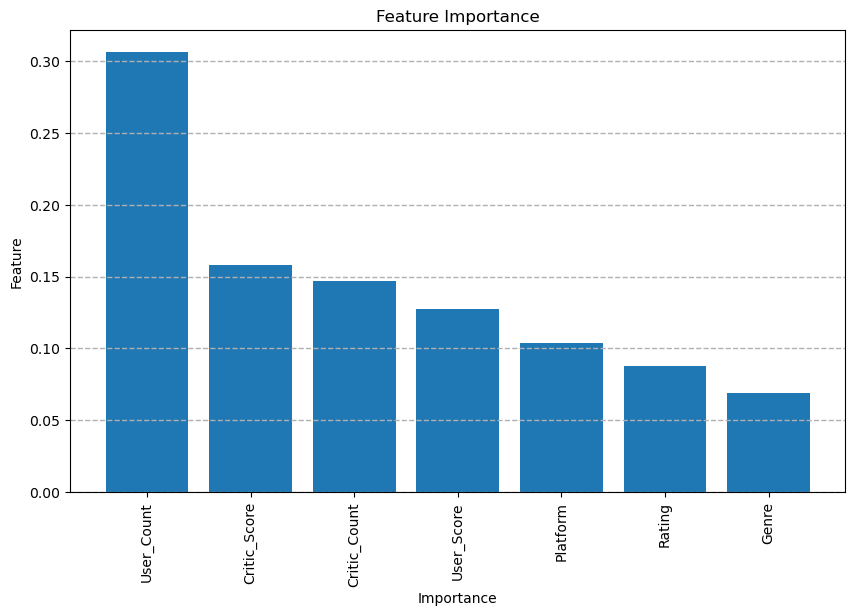

In [35]:
#setting up variables and test,train,split
X = df.drop(['Global_Sales'],axis=1)
y = df['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

# Seeing feature importance
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

# Ploting feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', linewidth=1.0)
plt.show()

In [36]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.07868541837805451
R-squared: 0.3066621144436391


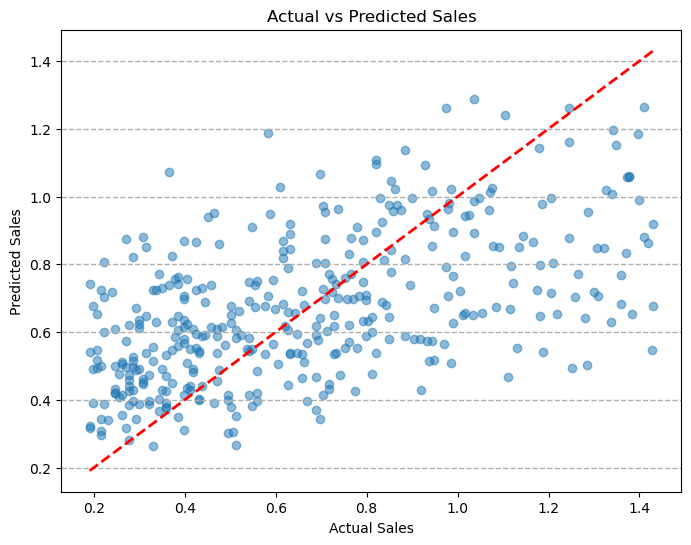

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.grid(axis='y', linestyle='--', linewidth=1.0)
plt.savefig('rfmodelpreictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
#hyper param tuning
from sklearn.model_selection import RandomizedSearchCV

parameter_range = {'n_estimators': [10, 50, 100],
                  'max_depth': [5,10, 20, 40, 80],
                  'min_samples_split': [2, 5, 10, 15],
                  'min_samples_leaf': [1, 2, 4, 10],
                  'max_features': ['auto', 'sqrt', 'log2']}
#searching
random_search = RandomizedSearchCV(estimator=model, param_distributions=parameter_range, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
#fit
best_param = random_search.fit(X_train, y_train)

print(best_param.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80}


In [41]:
#model2 building
rf2 = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1,max_features='sqrt', max_depth=40,random_state=16)
rf2.fit(X_train,y_train)

RandomForestRegressor(max_depth=40, max_features='sqrt', random_state=16)

In [43]:
y_pred2 = rf2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.07868541837805451
R-squared: 0.3066621144436391


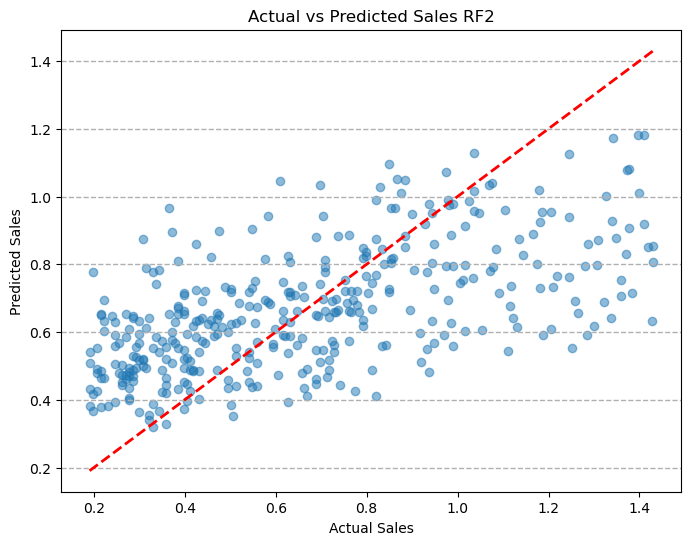

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred2, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales RF2')
plt.grid(axis='y', linestyle='--', linewidth=1.0)
plt.savefig('rfmodelpreictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Model is shwoing A tighter fit but is still quite large range. I beliee this is because of the nature of the data for videogame sales. 
# there will always be Outliers bcause of the nature of the videogame industry.